In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
from shapely.geometry import Polygon
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
#!pip install geopy
# !pip install fiona
import fiona

In [31]:
# Path to my File Geodatabase
gdb_path = '/Users/kd6801/Desktop/HI_map/HI_Structures.gdb'

# List all layers in the File Geodatabase
layers = fiona.listlayers(gdb_path)

# Read a specific layer into a GeoDataFrame
gdf = gpd.read_file(gdb_path, layer=layers[0])

In [140]:
fiona.listlayers(gdb_path)
# There is only one layer

['HI_Structures']

In [24]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 374703 entries, 0 to 374702
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   BUILD_ID      374703 non-null  int64         
 1   OCC_CLS       374703 non-null  object        
 2   PRIM_OCC      374703 non-null  object        
 3   SEC_OCC       0 non-null       object        
 4   PROP_ADDR     0 non-null       object        
 5   PROP_CITY     0 non-null       object        
 6   PROP_ST       374703 non-null  object        
 7   PROP_ZIP      0 non-null       object        
 8   OUTBLDG       0 non-null       object        
 9   HEIGHT        160128 non-null  float64       
 10  SQMETERS      374703 non-null  float64       
 11  SQFEET        374703 non-null  float64       
 12  H_ADJ_ELEV    0 non-null       object        
 13  L_ADJ_ELEV    0 non-null       object        
 14  FIPS          374703 non-null  object        
 15  CENSUSCOD

In [25]:
layers

['HI_Structures']

In [27]:
#gdf.plot()

In [28]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
gdf.iloc[0]

BUILD_ID                                                   915439
OCC_CLS                                              Unclassified
PRIM_OCC                                             Unclassified
SEC_OCC                                                      None
PROP_ADDR                                                    None
PROP_CITY                                                    None
PROP_ST                                                    Hawaii
PROP_ZIP                                                     None
OUTBLDG                                                      None
HEIGHT                                                        NaN
SQMETERS                                                201.55426
SQFEET                                                 2169.51001
H_ADJ_ELEV                                                   None
L_ADJ_ELEV                                                   None
FIPS                                                        15007
CENSUSCODE

## Now, we want to conduct spatial joins in geopandas

In [68]:
file_path_all = '/Users/kd6801/Desktop/Hilo_API/Hilo_all.json'
Hilo_api = pd.read_json(file_path_all)

In [78]:
Hilo_api.head()

pandas.core.frame.DataFrame

In [79]:
type(Hilo_api)

pandas.core.frame.DataFrame

In [81]:
#Hilo_api.iloc[0]
# We want to create a geometry column like this, because we have the longitude and latitude.
Hilo_api['geometry'] = Hilo_api.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [82]:
# Conver Pandas dataframe into GeoDataFrame
gdf_api = gpd.GeoDataFrame(Hilo_api, geometry='geometry')

In [94]:
# Ensure both geodataframes have the same coordinate reference system (CRS)
# The gdf_api previously does not have CRS set.
gdf_api.set_crs('EPSG:4326',inplace=True)
print(gdf_api.crs==gdf.crs)

True


In [105]:
joined = gpd.sjoin(gdf_api, gdf, how="inner", op='intersects')

/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [145]:
joined.iloc[11]

id                             101-Aupuni-St,-Ste-103,-Hilo,-HI-96720
formattedAddress               101 Aupuni St, Ste 103, Hilo, HI 96720
addressLine1                                            101 Aupuni St
addressLine2                                                  Ste 103
city                                                             Hilo
state                                                              HI
zipCode                                                         96720
county                                                         Hawaii
latitude                                                    19.717542
longitude                                                 -155.076647
propertyType                                                Apartment
squareFootage                                                   308.0
lotSize                                                           NaN
yearBuilt                                                      1971.0
assessorID          

In [114]:
print(f"The total number of buildings pulled from the RentCast API is {len(Hilo_api)}")
print(f"The total number of buildings contained in both FEMA and API is {len(joined)}")

The total number of buildings pulled from the RentCast API is 3785
The total number of buildings contained in both FEMA and API is 2059


In [133]:
# Define a threshold for what I consider a 'large' apartment
large_apartment_threshold = 3000
# Drop na
joined = joined.dropna(subset=['squareFootage','SQFEET'])
print(len(joined))
# Filter the dataset to include only large apartments
large_apartments_gdf = joined[joined['squareFootage'] >= large_apartment_threshold]
print(len(large_apartments_gdf))
large_apartments_gdf = large_apartments_gdf[large_apartments_gdf['SQFEET'] >= large_apartment_threshold]
print(len(large_apartments_gdf))

1976
55
49


In [172]:
# Define a threshold for what I consider a 'large' apartment
large_apartment_threshold_2 = 2000
print(len(joined))
# Filter the dataset to include only large apartments
large_apartments_gdf_2 = joined[joined['squareFootage'] >= large_apartment_threshold_2]
print(len(large_apartments_gdf_2))
large_apartments_gdf_2 = large_apartments_gdf_2[large_apartments_gdf_2['SQFEET'] >= large_apartment_threshold_2]
print(len(large_apartments_gdf_2))

1976
264
251


In [173]:
# Define a threshold for what I consider a 'large' apartment
large_apartment_threshold_3 = 1000
print(len(joined))
# Filter the dataset to include only large apartments
large_apartments_gdf_3 = joined[joined['squareFootage'] >= large_apartment_threshold_3]
print(len(large_apartments_gdf_3))
large_apartments_gdf_3 = large_apartments_gdf_3[large_apartments_gdf_3['SQFEET'] >= large_apartment_threshold_3]
print(len(large_apartments_gdf_3))

1976
1246
1239


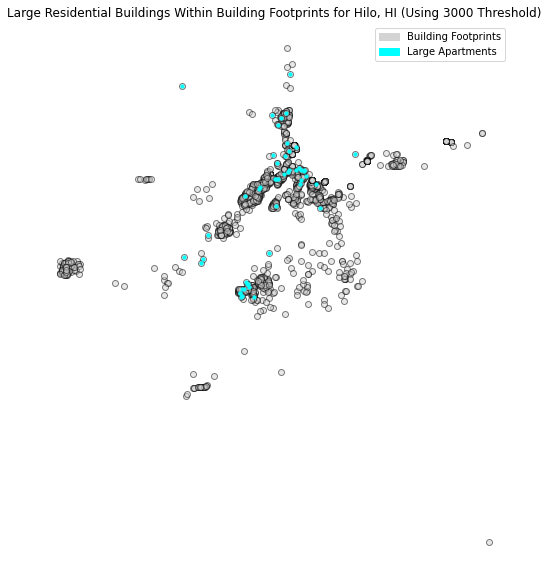

In [174]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the building footprints
joined.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Building Footprints')

# Plot the locations of large apartments
large_apartments_gdf.plot(ax=ax, color='cyan', markersize=10, label='Large Apartments')

# Create custom patches
building_patch = mpatches.Patch(color='lightgrey', label='Building Footprints')
apartment_patch = mpatches.Patch(color='cyan', label='Large Apartments')

# Add the custom patches to the legend
ax.legend(handles=[building_patch, apartment_patch])

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a title
ax.set_title('Large Residential Buildings Within Building Footprints for Hilo, HI (Using 3000 Threshold)')

# Optional: remove the axis for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

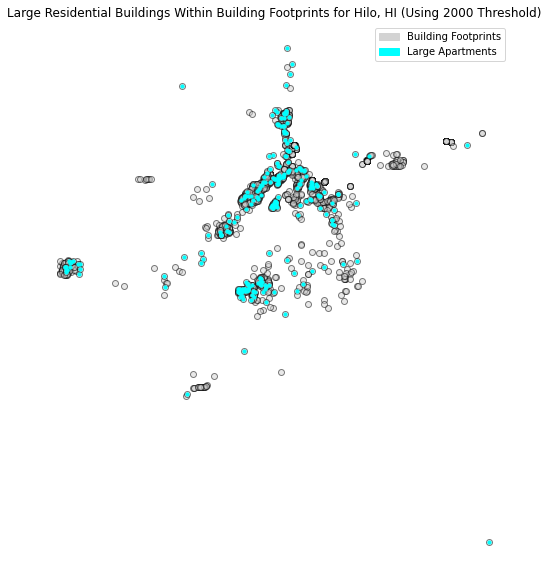

In [176]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the building footprints
joined.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Building Footprints')

# Plot the locations of large apartments
large_apartments_gdf_2.plot(ax=ax, color='cyan', markersize=10, label='Large Apartments')

# Create custom patches
building_patch = mpatches.Patch(color='lightgrey', label='Building Footprints')
apartment_patch = mpatches.Patch(color='cyan', label='Large Apartments')

# Add the custom patches to the legend
ax.legend(handles=[building_patch, apartment_patch])

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a title
ax.set_title('Large Residential Buildings Within Building Footprints for Hilo, HI (Using 2000 Threshold)')

# Optional: remove the axis for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

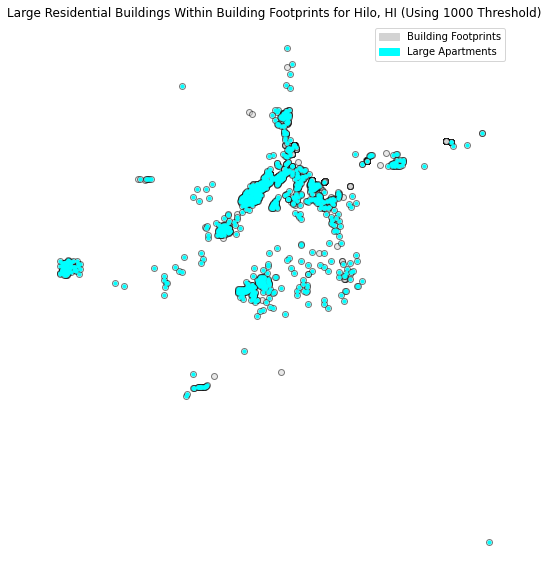

In [177]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the building footprints
joined.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Building Footprints')

# Plot the locations of large apartments
large_apartments_gdf_3.plot(ax=ax, color='cyan', markersize=10, label='Large Apartments')

# Create custom patches
building_patch = mpatches.Patch(color='lightgrey', label='Building Footprints')
apartment_patch = mpatches.Patch(color='cyan', label='Large Apartments')

# Add the custom patches to the legend
ax.legend(handles=[building_patch, apartment_patch])

# Add axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a title
ax.set_title('Large Residential Buildings Within Building Footprints for Hilo, HI (Using 1000 Threshold)')

# Optional: remove the axis for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

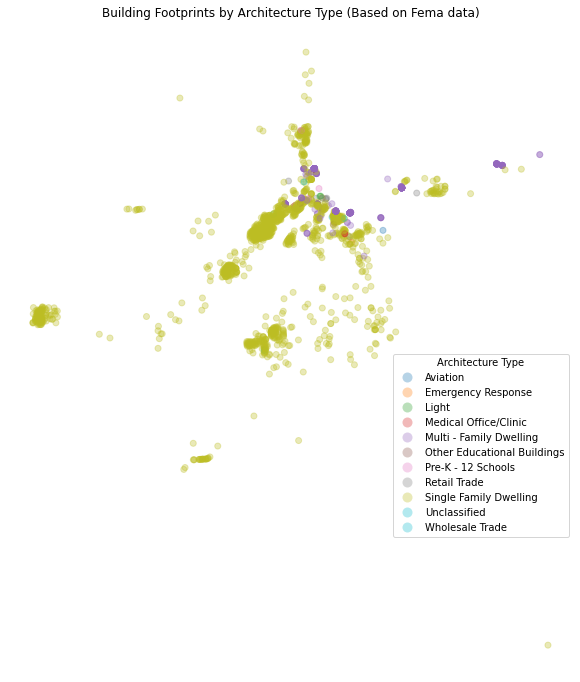

In [178]:
# Plot using different colors for different architecture types
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
joined.plot(column='PRIM_OCC', ax=ax, legend=True, alpha=0.32)

# Customize the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))
leg.set_title('Architecture Type')

# Set axis labels (if applicable)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a title
ax.set_title('Building Footprints by Architecture Type (Based on Fema data)')

# Remove the axis for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

In [179]:
# Extract 'architectureType' from the 'features' dictionaries into a new column
joined_drop_features = joined.dropna(subset=['features'])
joined_drop_features['architectureType'] = joined_drop_features['features'].apply(lambda x: x.get('architectureType', None))


/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


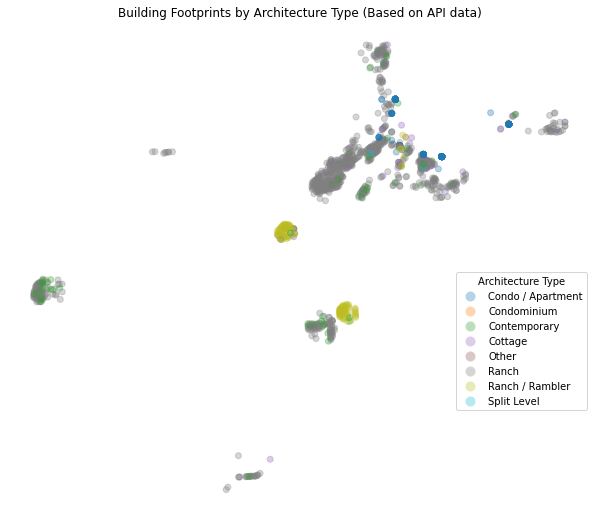

In [181]:
# Plot using different colors for different architecture types, based on API data
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
joined_drop_features.plot(column='architectureType', ax=ax, legend=True, alpha=0.32)

# Customize the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))
leg.set_title('Architecture Type')

# Set axis labels (if applicable)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a title
ax.set_title('Building Footprints by Architecture Type (Based on API data)')

# Remove the axis for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

### We see that
- It seems that most large apartments are associated with certain building footprints, perhaps indicating that larger buildings or complexes are more likely to contain larger apartments.
- The large apartments are not uniformly distributed; instead, they appear to be concentrated in specific areas. This could indicate neighborhoods or zones within the city where larger apartments are more common.
- There are clusters of large apartments, which could suggest high-rise residential areas or luxury apartment complexes.

To understand the context of these large apartments better, I might want to: 
1. compare them against various socioeconomic factors like median income, property values, or rental prices in those areas.

2. Investigating the proximity to amenities, public transport, and green spaces could also provide insights into the planning and desirability of these areas.


In [39]:
#Pulling Apartment data from the API for Hilo, HI

import requests

url_Hilo_apartment= "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Apartment&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_apartment = requests.get(url_Hilo_apartment, headers=headers).json()

In [41]:
len(response_apartment)

107

In [42]:
#Pulling Single family category residential data from the API for Hilo, HI
import requests

url_Hilo_single = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Single%20Family&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_single = requests.get(url_Hilo_single, headers=headers).json()
len(response_single)

500

In [43]:
#Pulling Single family category residential data from the API for Hilo, HI
import requests

url_Hilo_single2 = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Single%20Family&limit=500&offset=501"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_single2 = requests.get(url_Hilo_single2, headers=headers).json()
len(response_single2)

500

In [44]:
#Pulling Single family category residential data from the API for Hilo, HI
import requests

url_Hilo_single3 = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Single%20Family&limit=500&offset=1001"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_single3 = requests.get(url_Hilo_single3, headers=headers).json()
len(response_single3)

500

In [45]:
#Pulling Single family category residential data from the API for Hilo, HI
import requests

url_Hilo_single4 = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Single%20Family&limit=500&offset=1501"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_single4 = requests.get(url_Hilo_single4, headers=headers).json()
len(response_single4)

500

In [46]:
#Pulling Single family category residential data from the API for Hilo, HI
import requests

url_Hilo_single5 = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Single%20Family&limit=500&offset=2001"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_single5 = requests.get(url_Hilo_single5, headers=headers).json()
len(response_single5)

500

In [47]:
#Pulling Single family category residential data from the API for Hilo, HI
import requests

url_Hilo_single6 = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Single%20Family&limit=500&offset=2501"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_single6 = requests.get(url_Hilo_single6, headers=headers).json()
len(response_single6)

345

In [48]:
# Combined Single family data
combined_response_single = response_single+response_single2+response_single3+response_single4+response_single5+response_single6

In [49]:
len(combined_response_single)

2845

In [50]:
#condo
import requests

url_condo = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Condo&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_condo = requests.get(url_condo, headers=headers).json()
len(response_condo)

500

In [51]:
#condo
import requests

url_condo2 = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Condo&limit=500&offset=501"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_condo2 = requests.get(url_condo2, headers=headers).json()
len(response_condo2)

178

In [52]:
combined_condo = response_condo+response_condo2
len(combined_condo)

678

In [53]:
# Townhouse
import requests

url_townhouse = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Townhouse&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_townhouse = requests.get(url_townhouse, headers=headers).json()
len(response_townhouse)

8

In [54]:
# Multifamily
import requests

url_multifamily = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Multi-Family&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_multifamily = requests.get(url_multifamily, headers=headers).json()

len(response_multifamily)

12

In [55]:
# land
import requests

url_land = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Land&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_land = requests.get(url_land, headers=headers).json()

len(response_land)


135

In [56]:
#Manufactured
import requests

url_manu = "https://api.rentcast.io/v1/properties?city=Hilo&state=HI&propertyType=Manufactured&limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": "889bfd9166f14faa853a08628f388dbb"
}

response_manu = requests.get(url_manu, headers=headers).json()

len(response_manu)
# NOTHING in this category

0

In [58]:
# Save apartments
import json
with open('Hilo_apartment.json', 'w') as file:
    json.dump(response_apartment, file, indent=4)

In [59]:
with open('Hilo_single.json', 'w') as file:
    json.dump(combined_response_single, file, indent=4)

In [60]:
with open('Hilo_condo.json', 'w') as file:
    json.dump(combined_condo, file, indent=4)

In [61]:
with open('Hilo_townhouse.json', 'w') as file:
    json.dump(response_townhouse, file, indent=4)

In [62]:
with open('Hilo_land.json', 'w') as file:
    json.dump(response_land, file, indent=4)

In [63]:
with open('Hilo_multifamily.json', 'w') as file:
    json.dump(response_multifamily, file, indent=4)

In [64]:
Hilo_all = response_apartment+combined_response_single+combined_condo+response_townhouse+response_land+response_multifamily

In [65]:
with open('Hilo_all.json', 'w') as file:
    json.dump(Hilo_all, file, indent=4)